In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [14]:
df = pd.read_csv('files/weatherAUS.csv')
df

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [15]:
def city_dataframe(city):
    df_city = df[df['Location'] == city]
    return df_city

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 50))
    plt.show()

In [16]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [17]:
df.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

In [18]:
#Show all diferent cities
cities=df['Location'].unique()
print(cities)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


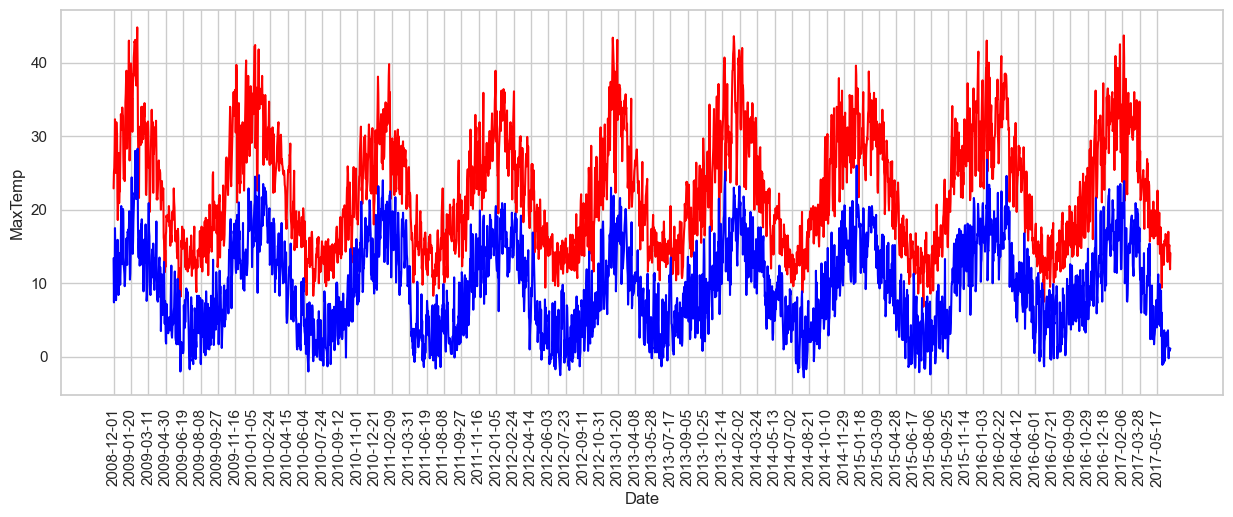

In [19]:
plot_temperature(city_dataframe('Albury'))

In [58]:
def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.drop(['Unnamed: 0','Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_rows, 20 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=30)
        axs[row, col_idx].set_ylabel("Count",fontsize=20)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=20)
        axs[row, col_idx].tick_params(axis='y', labelsize=20)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    # Añade un título general a la figura
    if len(df['Location'].unique()) == 1:
        fig.suptitle(f"Histogramas de Variables Numéricas: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Histogramas de Variables Numéricas", fontsize=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

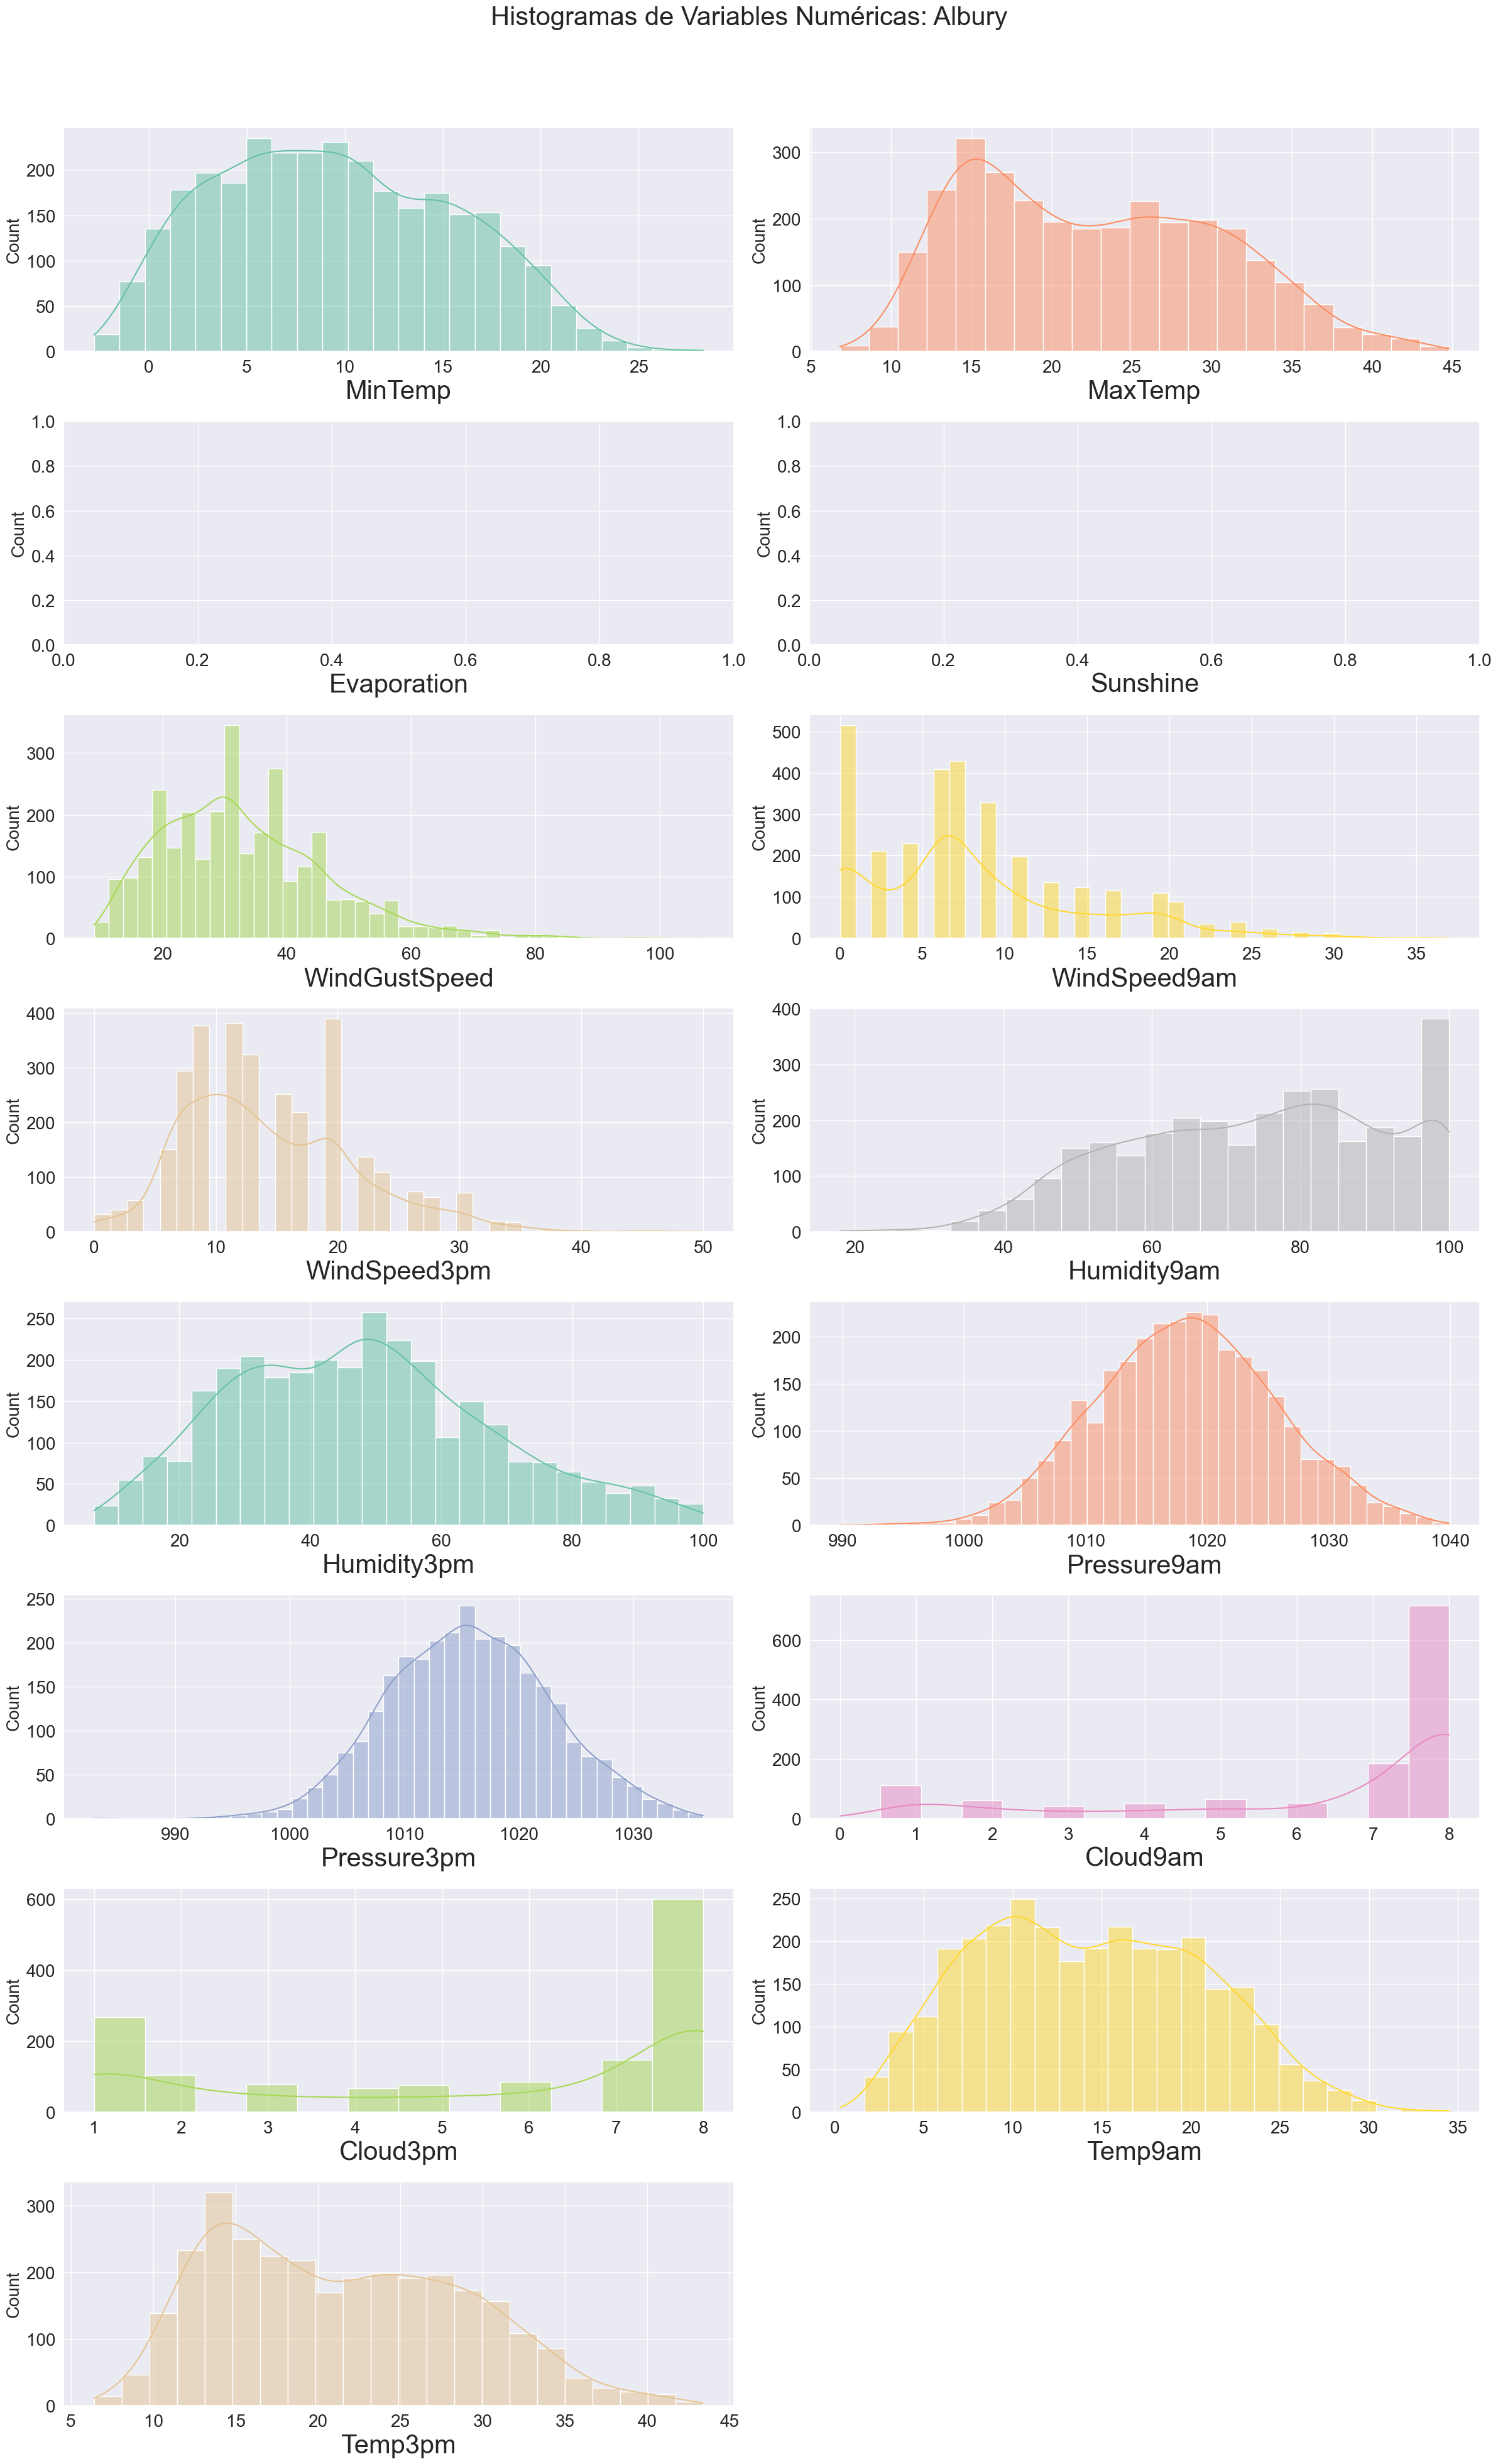

In [59]:
plot_variables(city_dataframe('Albury'))

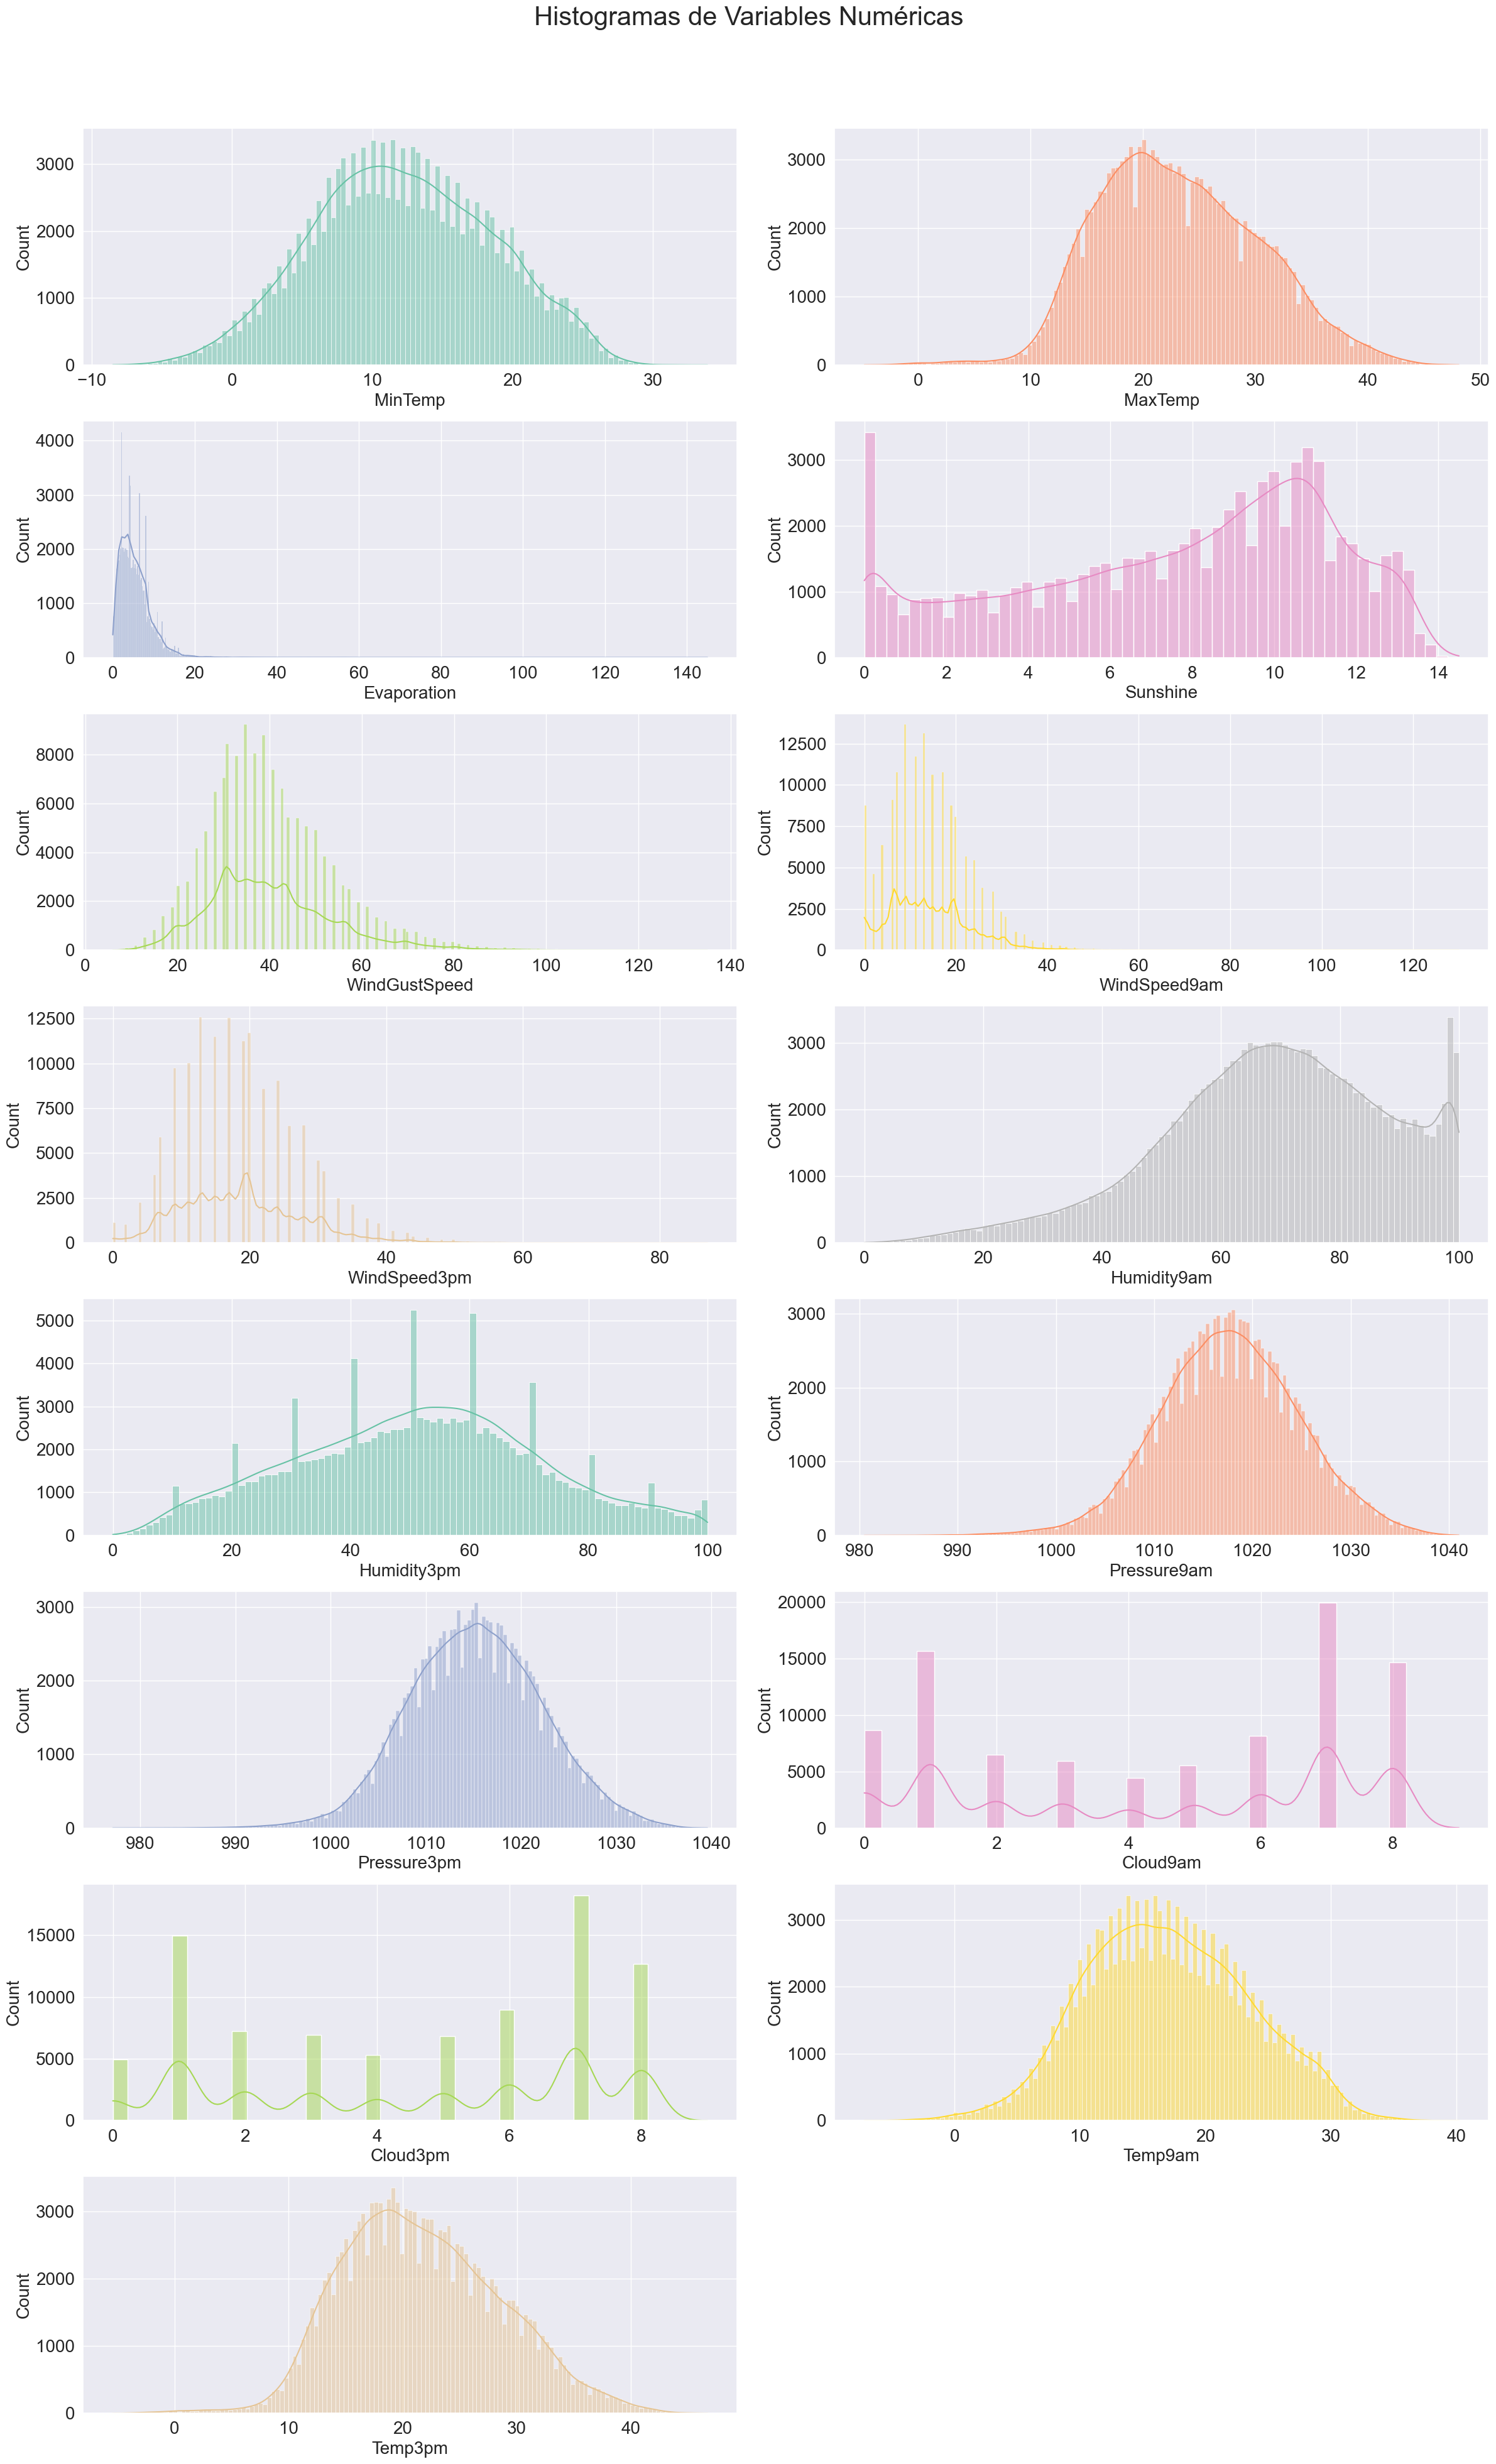

In [55]:
plot_variables(df)

In [66]:
# Obtiene una lista de todas las columnas numéricas del DataFrame
non_numeric_columns = df.drop(['Unnamed: 0','Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[object]).columns
non_numeric_dataframe = df[non_numeric_columns]
non_numeric_dataframe

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...,...
145407,2017-06-20,Uluru,E,ESE,E,No,No
145408,2017-06-21,Uluru,E,SE,ENE,No,No
145409,2017-06-22,Uluru,NNW,SE,N,No,No
145410,2017-06-23,Uluru,N,SE,WNW,No,No


In [69]:
wind=df['WindGustDir'].unique()
print(wind)

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']


In [71]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')